In [1]:
import os
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
# 查看GPU是否可用
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
from sklearn.preprocessing import scale
def load_data(data_name,label_name):
    path_x=os.path.join('train_data',data_name)
    path_y=os.path.join('train_data',label_name)
    # 读取数据
    x = np.load(path_x)
#     scaler = MinMaxScaler()
#      x = scaler.fit_transform(x)
    x=scale(x)
    y = np.load(path_y)
    num = len(Counter(y))
    print("类别数量为：", num)
    return x, y, num

In [3]:
def create_train_data(x, y, ratio=0.7):
    """
    x:data
    y:labal
    ratio:生成训练集比率
    """
    # 打乱顺序
    # 读取data矩阵的第一维数（数据个数）
    num_example = x.shape[0]
    # 产生一个num_example范围，步长为1的序列
    arr = np.arange(num_example)
    # 调用函数，打乱顺序
    np.random.seed(99)
    np.random.shuffle(arr)
    # 按照打乱的顺序，重新排序
    arr_data = x[arr]
    arr_label = y[arr]
    # 将数据集分为训练集80%、测试集20%
    s = int(num_example * ratio)
    x_train = arr_data[:s]
    y_train = arr_label[:s]
    x_val = arr_data[s:]
    y_val = arr_label[s:]
    print("训练集shape", x_train.shape)
    print("训练集类别：", Counter(y_train))
    print("测试集shape", x_val.shape)
    print("测试集类别：", Counter(y_val))
    return x_train, y_train, x_val, y_val

In [4]:
# 读取数据
data, label, label_count= load_data('train_data_wavelet.npy','label_wavelat.npy')
# 生成训练集测试集,70%用作训练，30%用作测试
train_data, train_label, val_data, val_label= create_train_data(data, label, 0.8)
print("*"*10)
print("训练集数量：",len(train_label))
print("测试集数量：",len(val_label))

FileNotFoundError: [Errno 2] No such file or directory: 'train_data\\label_wavelat.npy'

# 模型优化

In [6]:
from tensorflow.keras.layers import  LSTM,Bidirectional

In [8]:
def cnnbilstm_optimize1():
    loss = 'sparse_categorical_crossentropy'
    metrics = ['acc']
    inputs = keras.Input(shape=(2014,1))
    #CNN+POOLING
    x = layers.Conv1D(128, 3, activation='relu')(inputs)
    x = layers.Conv1D(128, 3, activation='relu')(x)
    x = layers.MaxPooling1D(16)(x)
    x = layers.Conv1D(64, 3, activation='relu')(x)
    x = layers.MaxPooling1D(16)(x)
    #BiLSTM
    #x=Bidirectional(LSTM(128,return_sequences=True))(x)
    x=Bidirectional(LSTM(128))(x)
    outputs = layers.Dense(4, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop',
                  loss=loss,
                  metrics=metrics)
    print("实例化模型成功，参数如下：")
    print(model.summary())
    return model

In [9]:
# 实例化模型
cnnbilstm_model = cnnbilstm_optimize1()

# 设置模型log输出地址
log_dir = os.path.join("logs/optimize1")
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

实例化模型成功，参数如下：
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2014, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2012, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2010, 128)         49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 125, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 123, 64)           24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)

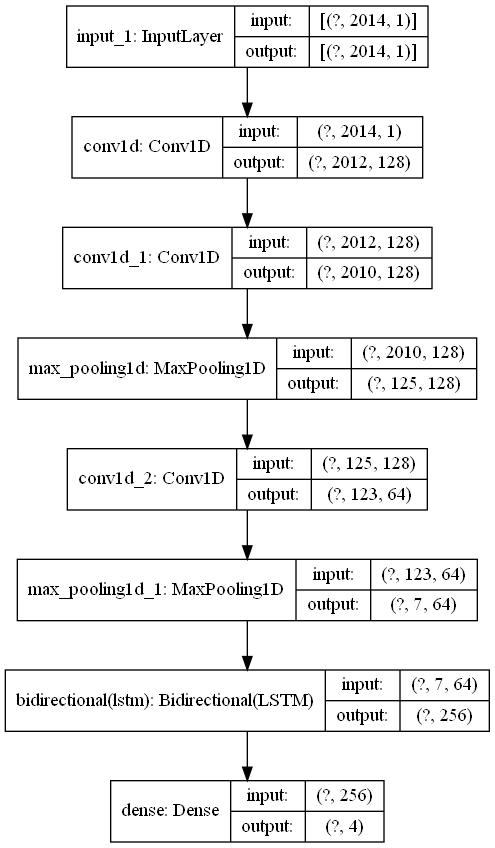

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(cnnbilstm_model, to_file=r'modle2.png', show_shapes=True)

In [23]:
# 模型训练
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = cnnbilstm_model.fit(train_data, train_label,epochs=30, batch_size=32, validation_split=0.2,callbacks=[tensorboard_callback])

Epoch 1/30
 1/94 [..............................] - ETA: 0s - loss: 1.3470 - acc: 0.2812WARNING:tensorflow:From C:\Users\wuson\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
94/94 [==============================] - 8s 83ms/step - loss: 0.5927 - acc: 0.6829 - val_loss: 0.4412 - val_acc: 0.7031
Epoch 2/30
94/94 [==============================] - 7s 71ms/step - loss: 0.3585 - acc: 0.7831 - val_loss: 0.2961 - val_acc: 0.8429
Epoch 3/30
94/94 [==============================] - 7s 71ms/step - loss: 0.2988 - acc: 0.8348 - val_loss: 0.2877 - val_acc: 0.8256
Epoch 4/30
94/94 [==============================] - 7s 70ms/step - loss: 0.2907 - acc: 0.8428 - val_loss: 0.3052 - val_acc: 0.8162 loss: 0.290
Epoch 5/30
94/94 [==============================] - 7s 71ms/step - loss: 0.2705 - acc: 

In [24]:
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,accuracy_score,log_loss
print("*****完成预处理，进行模型评估*****")
y_pred = cnnbilstm_model.predict(val_data)
y_pred = [np.argmax(x) for x in y_pred]
print('------------------测试集上得分：------------------------')
print('*' * 5)
print('测试集准确率得分:', round(accuracy_score(val_label, y_pred),3))
print('*' * 5)
print('准确率、召回率、f1-值测试报告如下:\n', classification_report(val_label, y_pred))

*****完成预处理，进行模型评估*****
------------------测试集上得分：------------------------
*****
测试集准确率得分: 0.973
*****
准确率、召回率、f1-值测试报告如下:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       230
           1       1.00      0.90      0.95       241
           2       0.91      1.00      0.95       239
           3       1.00      1.00      1.00       229

    accuracy                           0.97       939
   macro avg       0.98      0.97      0.97       939
weighted avg       0.98      0.97      0.97       939



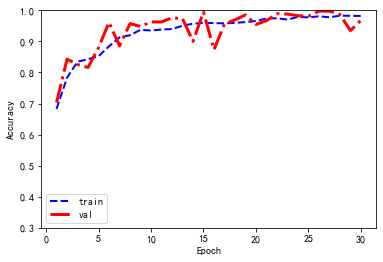

In [25]:
# 设置Y轴范围
plt.ylim(0.3,1)
# 训练准确率曲线
show_data1_cnnbilstm= history.history['acc']
# 测试准确率曲线
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
show_data2_cnnbilstm= history.history['val_acc']
x_data = list(range(1,len(show_data1_cnnbilstm)+1))
ln1, = plt.plot(x_data,show_data1_cnnbilstm,color='blue',linewidth=2.0,linestyle='--')
ln2, = plt.plot(x_data,show_data2_cnnbilstm,color='red',linewidth=3.0,linestyle='-.')
plt.legend(handles=[ln1,ln2],labels=['train','val'])
plt.show()

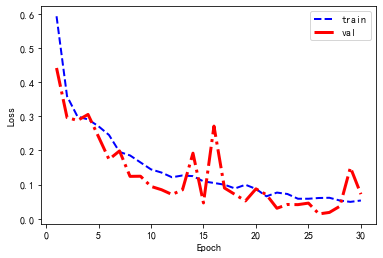

In [26]:
#loss曲线
# 设置Y轴范围
#plt.ylim(0.3,1)
# 训练准确率曲线
show_data1_cnnbilstm= history.history['loss']
# 测试准确率曲线
plt.ylabel("Loss")
plt.xlabel("Epoch")
show_data2_cnnbilstm= history.history['val_loss']
x_data = list(range(1,len(show_data1_cnnbilstm)+1))
ln1, = plt.plot(x_data,show_data1_cnnbilstm,color='blue',linewidth=2.0,linestyle='--')
ln2, = plt.plot(x_data,show_data2_cnnbilstm,color='red',linewidth=3.0,linestyle='-.')
plt.legend(handles=[ln1,ln2],labels=['train','val'])
plt.show()